# How to get Data?

You need to create a developer account on twitter in order to read the data through API. Once you create the account, you need to create an app (*just consider it as a sub-acccount*) and get access keys. Visit the below link to know how?

https://developer.twitter.com/en/apply-for-access


# Install Required Packages

In [12]:
!pip install wordcloud
!pip install spacy
!pip install tweepy

#it may be possible that below models wont install through spacy package
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

# Downloading Data
For this experiment, we will be using 2000 tweets posted under hashtags #coronavirus, #COVID19 and #CoronavirusOutbreak. We cant get tweets older than 7 days from API. I have used API.search method and tweets will be saved as a json string into a file named data.json for easy parsing.
You  can also pull data by passing various methods and get different type of data like retweets,followers,etc. Below is the link for various wrapper methods:

http://docs.tweepy.org/en/latest/api.html#tweepy-api-twitter-api-wrapper

In [15]:
import tweepy as tw
import pandas as pd
import json

# App Auth : get these authetication keys from dev.twitter.com
consumer_key = 'XXXXXXXXX'
consumer_secret = 'XXXXXXXXXX'
access_key = 'XXXXXXXXXX'
access_secret = 'XXXXXXXXXXX'

# Initialize API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Search terms
search_words = ["#coronavirus", "#COVID19", "#CoronavirusOutbreak"]
# Mention the from date
date_since = "2020-04-01"

# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
                   #result_type='popular',
                   include_entities = False,
              since=date_since, #tweet_mode='extended',
              include_rts=False).items(2000)

tweets_arr = []

# Iterate and print tweets
for tweet in tweets:
    tweets_arr.append(tweet._json)
print("Done")

#Get the data in dataframe
df = pd.DataFrame(tweets_arr)
df.head(3)

#store the tweets in json for future use
with open("data.json", "w+") as output:
    output.write(json.dumps(tweets_arr))

Done


# Reuse the tweets in json file

In [243]:
# Reading json file from path 
import pandas as pd

#Get the data in dataframe
df= pd.read_json("data.json")
df.head(1)

,created_at,id,id_str,text,truncated,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status
0,2020-05-10 09:37:15+00:00,1259417204753346561,1259417204753346560,RT @DrDenaGrayson: I appeared on @SkyNews and ...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,False,4767,0,False,False,en,NaN,NaN,NaN,NaN


# Wordcloud Using PorterStemmer

## Preprocessing Data
Since we are downloading data from a public source, we must use some preprocessing in order to retain useful wordings for downstream analysis. There are few common techniques of preprocessing natural language content.

#### Tokenisation
Here we break text into sentences i.e. sentence tokenisation and break sentences again into works i.e. word tokenisation. In this article we will perform word tokenisation at once since tweets are mostly shorter than typical social media content.

#### Removal of stop words
The English language consists of several stop words that add meaning in sentences but not in context. For example words such as is are was has , etc. do not add value for our use case.

#### Lexicon Normalisation
This is the process where we get rid of forms of words thus retaining a single representation. For example; play, playing, playable, etc. can be reduced to “play” and retain the core meaning.

There are two forms of this normalisation.
1. Stemming — This is where we get rid of affixes (prefixes and suffixes). The example related to the word “play” comes under this category
2. Lemmatisation — This is where we do stemming with context awareness. For example, knowing whether a word is a noun or a verb has a significant effect on stemming. For example; dryer might turn out to be dry whereas it actually is a noun. 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


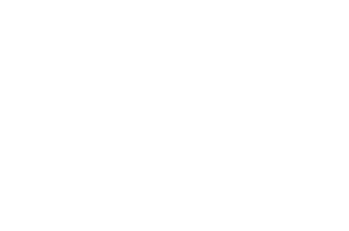

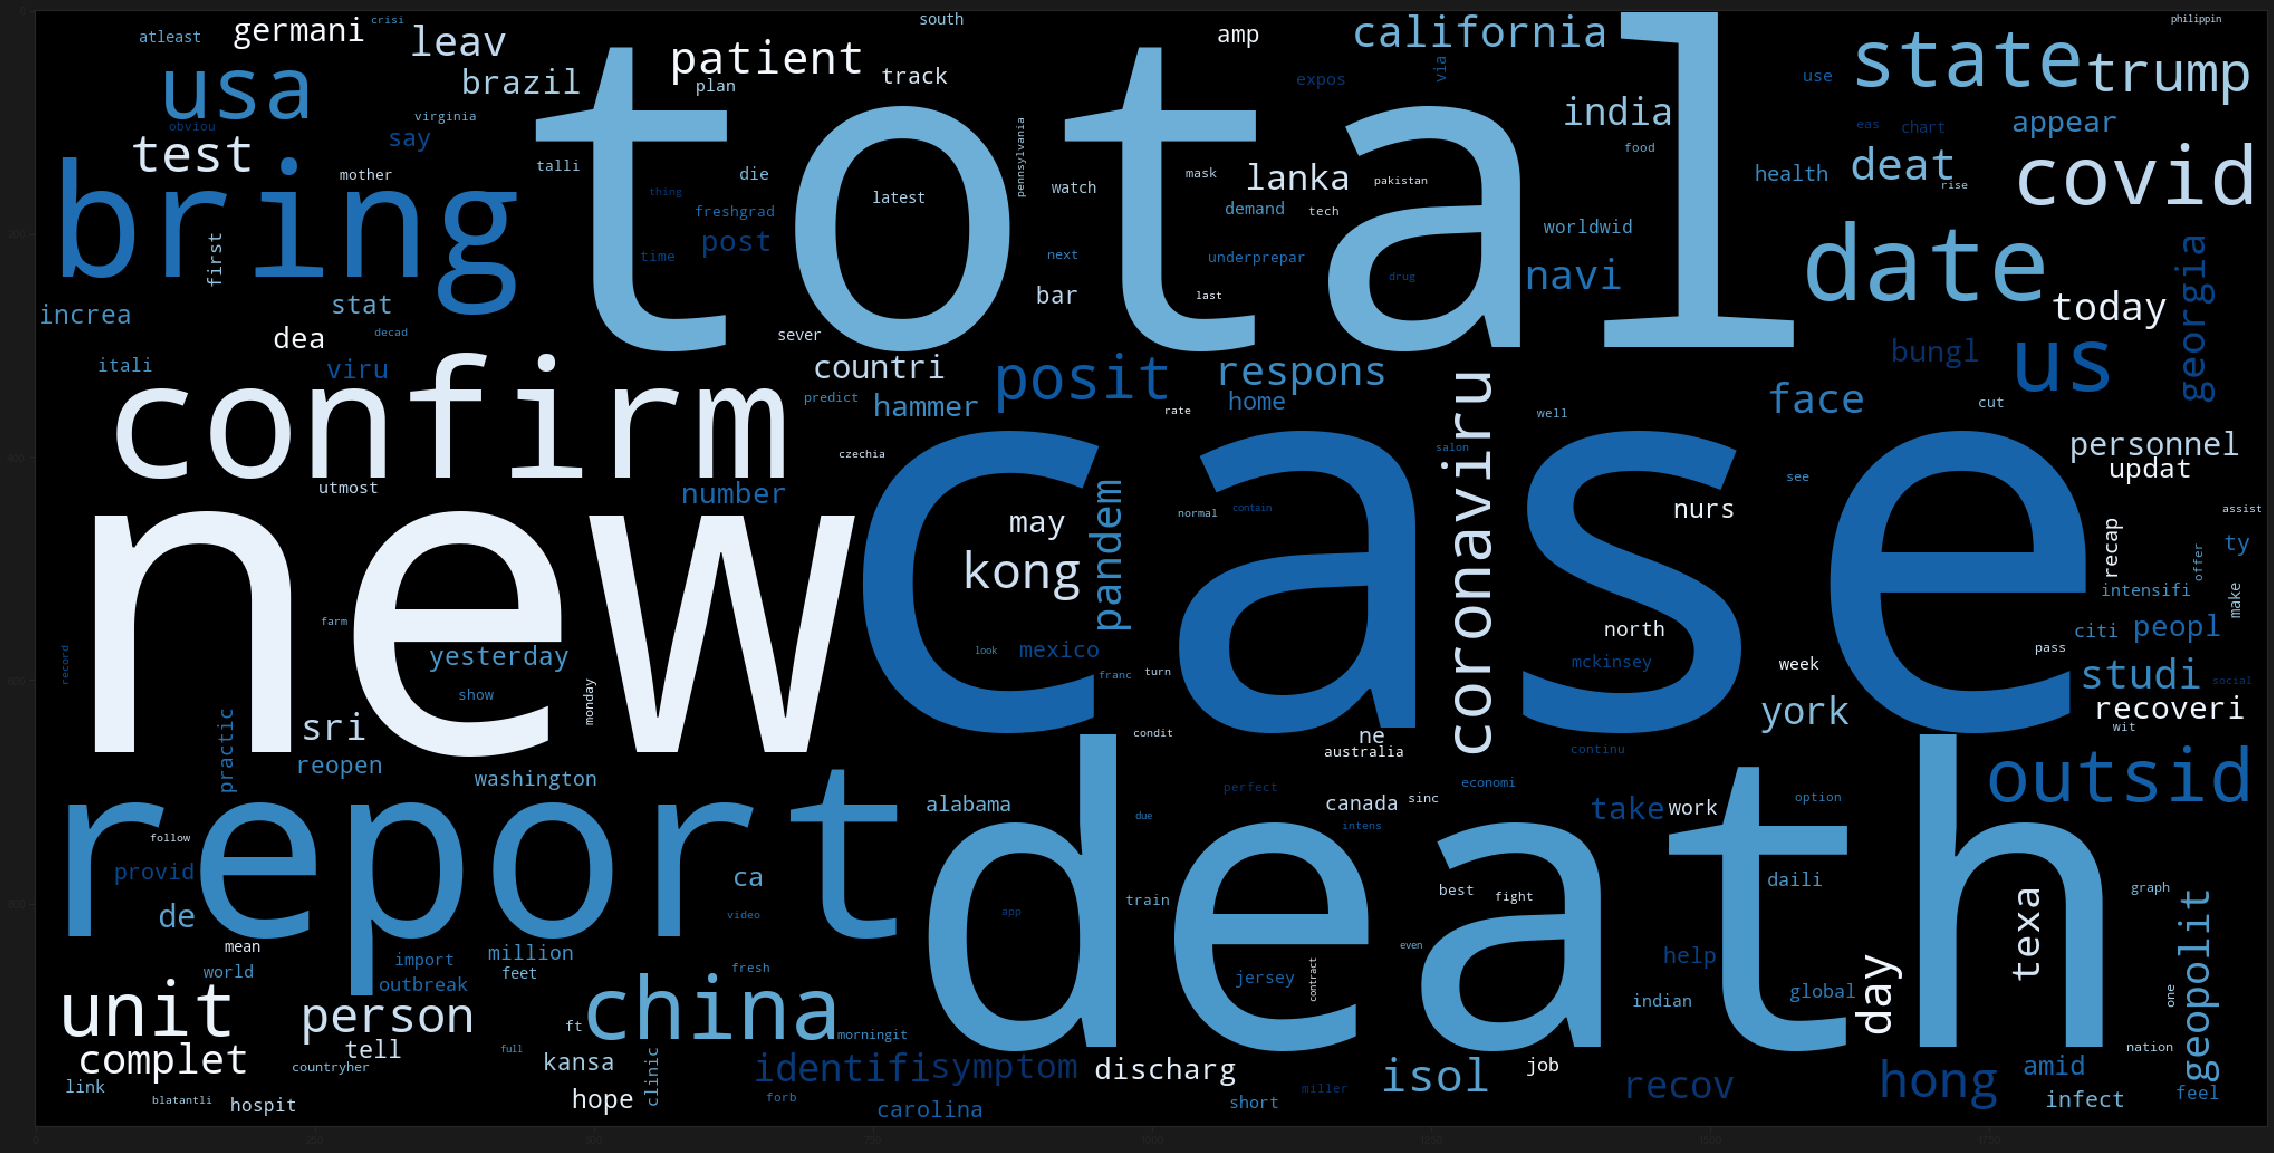

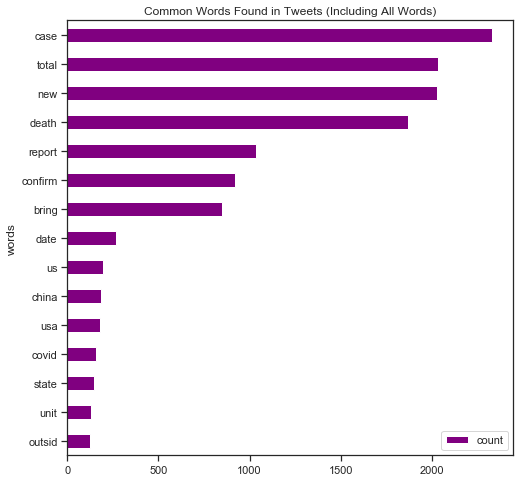

In [244]:

# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string

# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt

# seaborn import
import seaborn as sns

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
tf = TfidfVectorizer()

sentences =[]
sentences_processed=[]

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

for tweet_text in df.text:
        # remove mentions, hashtags and punctuatoins
        tweet_text = re.sub(r'RT', '', tweet_text).lower()
        tweet_text1 = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', tweet_text)
        tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
        #remove urls from tweets
        tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
        tweet_text4 = deEmojify(tweet_text3)
        tweet_text5 = tweet_text4.translate(str.maketrans('', '', string.punctuation))
        sentences.append(tweet_text5)
        
# At this point we have sentences
for sentence in sentences:
    # Obtain work tokens
    tokenized_words = word_tokenize(sentence)
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, tokenized_words))
    # Stemming words (lematization is better but requires POS tagging which)
    stemmed_words = list(map(ps.stem, filtered_words))
    #stemmed_words = list(map(lemmatizer.lemmatize, filtered_words))
    sentences_processed.append(" ".join(stemmed_words))

words_in_tweet = [tweet.lower().split() for tweet in sentences_processed]

#print(words_in_tweet)

all_words_nsw = list(itertools.chain(*words_in_tweet))

counts_nsw = collections.Counter(all_words_nsw)

#print(counts_nsw.most_common(100))

#####################################################################################################

# Word cloud for most mentioned words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += " " + ele   
    
    # return string   
    return str1  

all_words=listToString(all_words_nsw)


# Create the wordcloud object
wordcloud = WordCloud(width=2000, height=1000,collocations=False, margin=5,colormap="Blues").generate(all_words)
 
# Display the generated image:
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (40, 30),facecolor = 'k',edgecolor = 'k')
plt.margins(x=0, y=0)
plt.imshow(wordcloud )

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
pd.DataFrame(counts_nsw.most_common(15),columns=['words','count']).sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#####################################################################################################


# Wordcloud Using Wordnet lemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('case', 2330), ('total', 2035), ('new', 2027), ('death', 1866), ('report', 1032), ('confirm', 903), ('bring', 850), ('date', 269), ('china', 185), ('usa', 183), ('covid', 161), ('state', 146), ('united', 132), ('outside', 128), ('coronavirus', 93)]
 
 
 


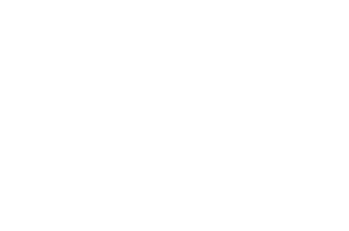

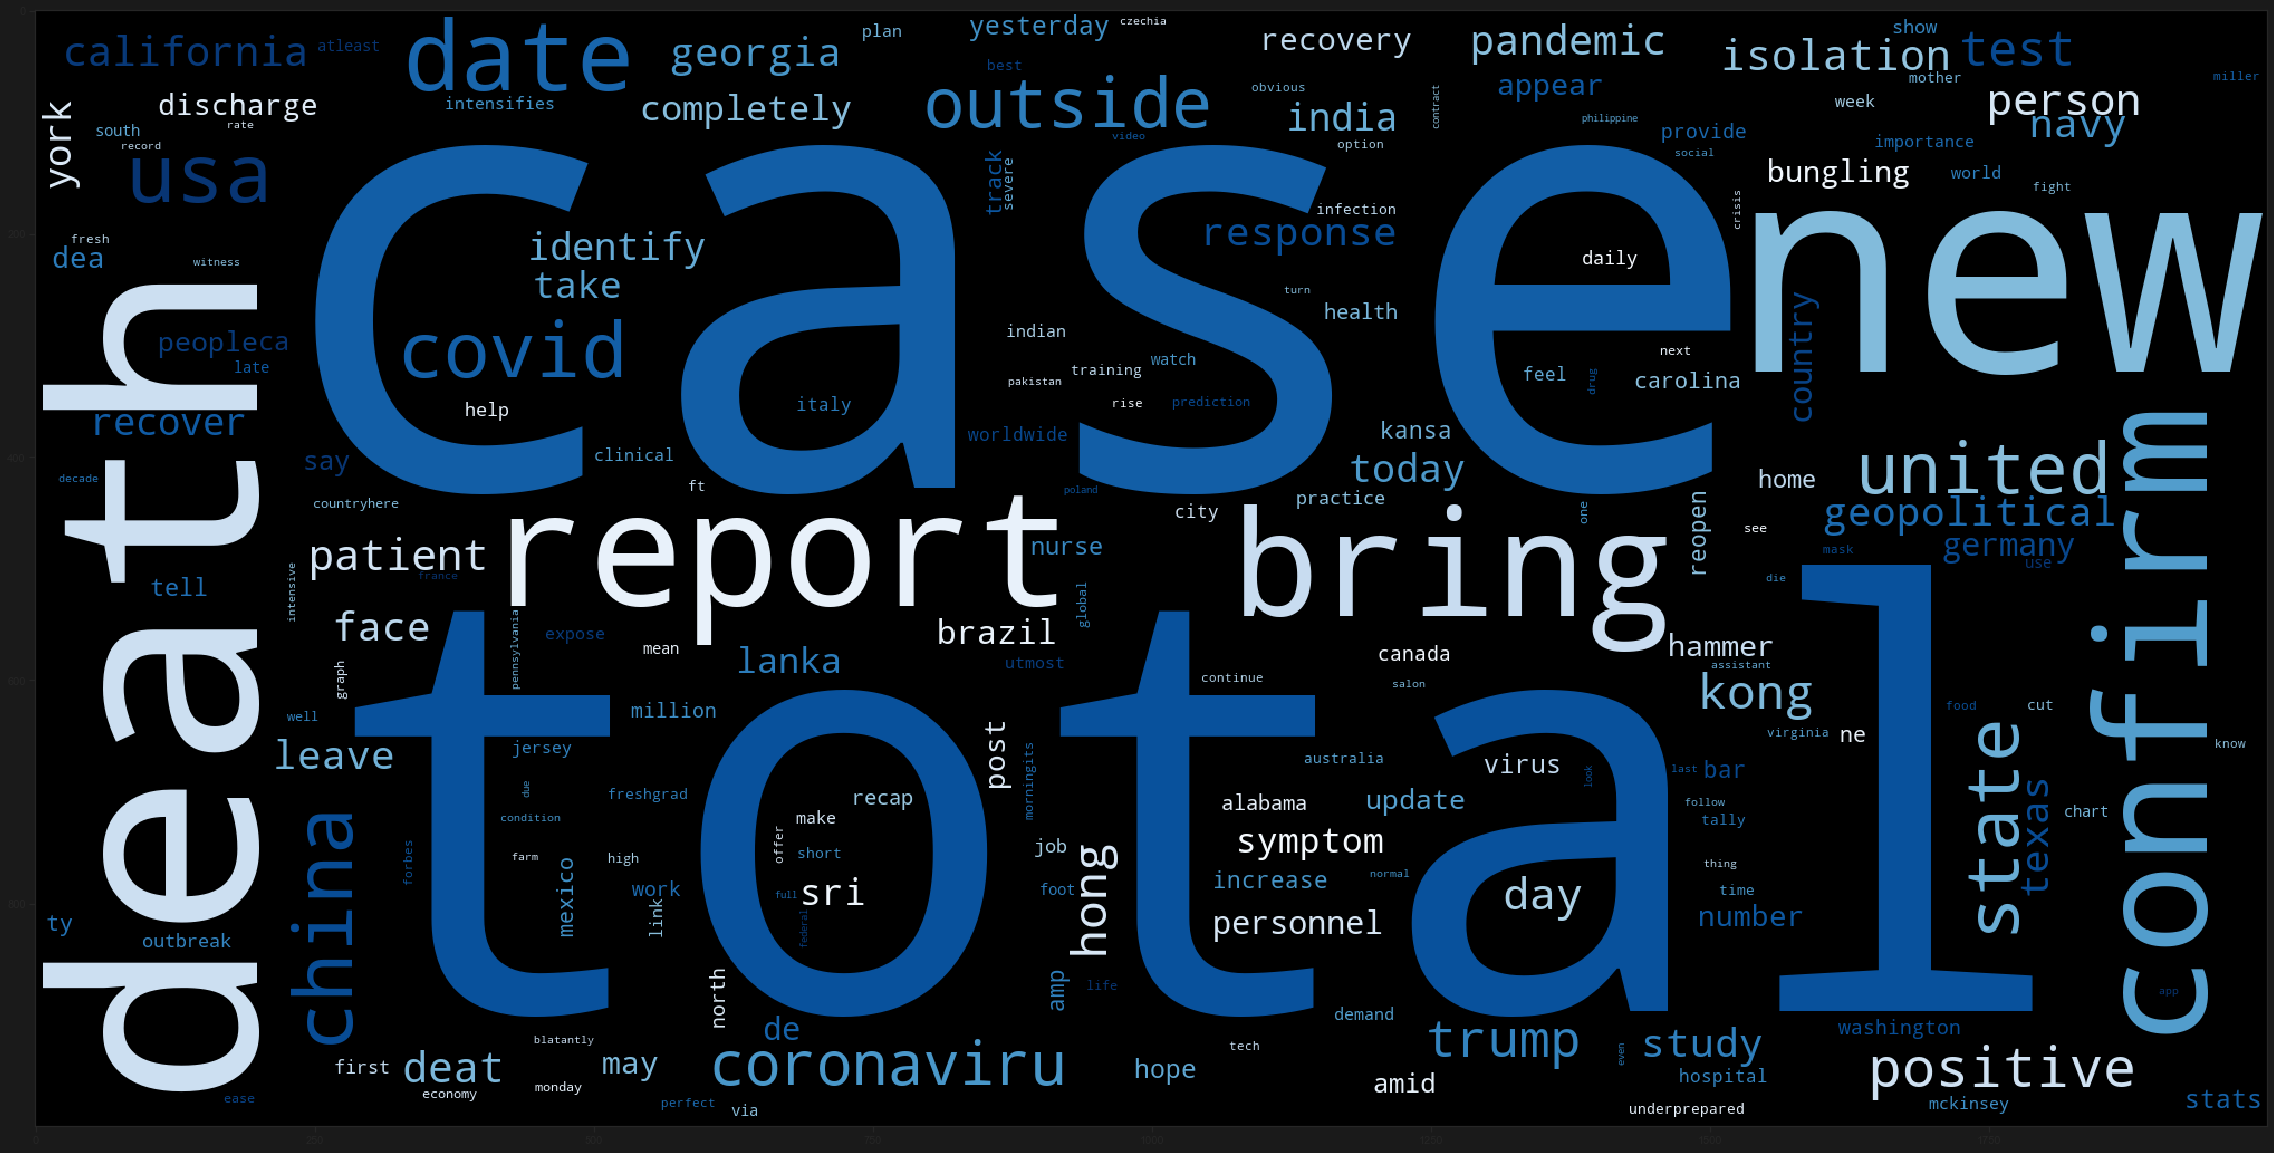

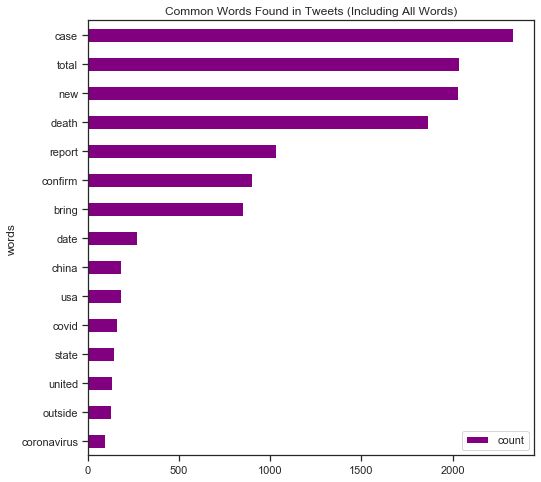

In [245]:
# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import *
from nltk.stem.snowball import *

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string


# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt

# seaborn import
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# preprocessor data sources and instances
stop_words = set(stopwords.words("english"))
stop_words.add('u')
ps = PorterStemmer()
tf = TfidfVectorizer()
sb = SnowballStemmer("english")

sentences= []
stemmed_words_wn=[]

for tweet_text in df.text:
        # remove mentions, hashtags and punctuatoins
        tweet_text = re.sub(r'RT', '', tweet_text).lower()
        tweet_text1 = re.sub(r'@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|[0-9]+|,|\'|\"|\`|…', '', str(tweet_text))
        tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
        #remove urls from tweets
        tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
        tweet_text4 = deEmojify(tweet_text3)
        tweet_text5 = tweet_text4.translate(str.maketrans('', '', string.punctuation))
        sentences.append(tweet_text5)

# At this point we have sentences
for sentence in sentences:
    # Obtain work tokens
    tokenized_words = word_tokenize(sentence)
    # Stemming words (lematization is better but requires POS tagging which)
    stemmed_words_sb = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_words]
    # Remove stop words
    filtered_words = list(filter(lambda x: x not in stop_words, stemmed_words_sb))
    stemmed_words_wn.append(filtered_words)


words_in_tweet = [tweet for tweet in stemmed_words_wn]

all_words_nsw = list(itertools.chain(*words_in_tweet))

counts_nsw = collections.Counter(all_words_nsw)

print(counts_nsw.most_common(15))

#####################################################################################################

# Word cloud for most mentioned words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += " " + ele   
    
    # return string   
    return str1  

all_words=listToString(all_words_nsw)

mostcommon_words = pd.DataFrame(counts_nsw.most_common(15),columns=['words','count']).sort_values(by='count')

##########################################################################################

# Create the wordcloud object
wordcloud = WordCloud(width=2000, height=1000,collocations=False, margin=5,colormap="Blues").generate(all_words)
 
# Display the generated image:
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (40, 30),facecolor = 'k',edgecolor = 'k')
plt.margins(x=0, y=0)
plt.imshow(wordcloud )

print( " \n \n ")

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
mostcommon_words.plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()
#####################################################################################################


# Difference betwwen Stemmer and Lemmatizer 

From the above two plots we can see the Lemmatizer with POS tag gives more accurate keys than stemmer. Have a look at words like Outside, coronavirus, pandemic, etc.

# Sentimental Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


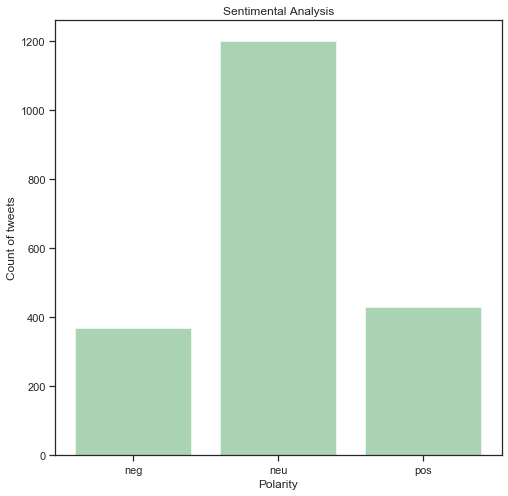

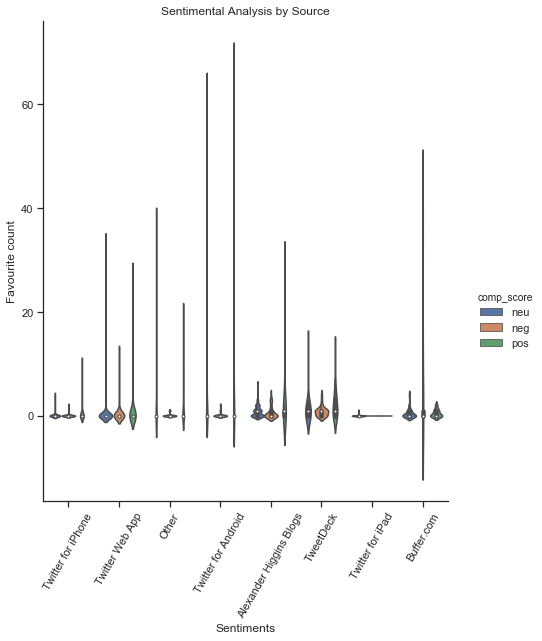

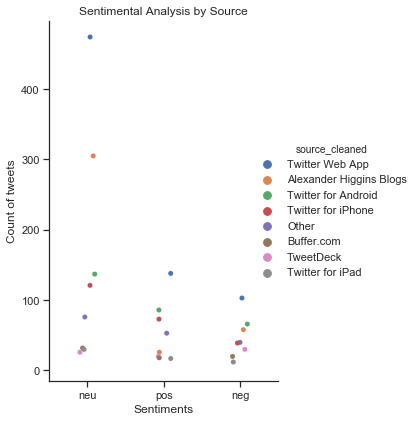

In [240]:
# NLP imports
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# pandas
import pandas as pd
import itertools
import collections
import string
import numpy as np 

# python imports
import re
import json
from collections import Counter
from matplotlib import pyplot as plt


# preprocessor data sources and instances
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# seaborn import
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
tf = TfidfVectorizer()

#Funtion to remove the emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

#Classify sentiments as positive, negative and neutral
def sentiment_classifier(value):
    if value>0:
        senti= 'pos'
    elif value<0:
        senti= 'neg'
    else: 
        senti= 'neu'
    return senti

#Classify sources
def sentiment_classifier(value):
    if value>0:
        senti= 'pos'
    elif value<0:
        senti= 'neg'
    else: 
        senti= 'neu'
    return senti

def clean_tweet(df):
    # remove mentions, hashtags and punctuatoins
    tweet_text1 = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|,|\'|\"|\`|…', '', str(df))
    tweet_text2 = re.sub(r'  ', ' ', tweet_text1.strip())
    #remove urls from tweets
    tweet_text3 = re.sub(r'http\S+', '', tweet_text2, flags=re.MULTILINE) 
    return tweet_text3

## declare blank list to clean source column
source_cured=[]

def source_curator(source):
    for j in source:
        k = re.sub(r' ', '', j.strip())
        l = re.sub(r'RT|@[a-zA-Z0-9_]+|:|#[a-zA-Z0-9_]+|,|\'|\"|\`|…', '', str(k))
        i = pd.Series(l)
        if i.str.contains('TwitterforiPad').any():
            source_cured.append("Twitter for iPad")
        elif i.str.contains('TwitterforAndroid',).any():
            source_cured.append("Twitter for Android")
        elif i.str.contains('TwitterWebApp').any():
            source_cured.append("Twitter Web App")
        elif i.str.contains('TwitterforiPhone').any():
            source_cured.append("Twitter for iPhone")
        elif i.str.contains('AlexanderHiggins').any():
            source_cured.append("Alexander Higgins Blogs")
        elif i.str.contains('TweetDeck').any():
            source_cured.append("TweetDeck")
        elif i.str.contains('Buffer').any():
            source_cured.append("Buffer.com")
        else: 
            source_cured.append("Other")    
    return source_cured


df['cleaned_tweet'] = df['text'].apply(lambda text: clean_tweet(text))
df['source_cleaned'] = source_curator(df['source'])

# get the polarity scores
df['scores'] = df['cleaned_tweet'].apply(lambda cleaned_tweet: analyser.polarity_scores(cleaned_tweet))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda compound: sentiment_classifier(compound))

#######################################################################################

x = sorted(df['comp_score'].unique().tolist())
y = df['id'].groupby(df['comp_score']).size().tolist()
y_pos = np.arange(len(x))

#######################################################################################

fig, ax = plt.subplots(figsize=(8, 8))

plt.bar(x, y, align='center', alpha=0.5, color = 'g')
plt.xticks(y_pos, x)
plt.ylabel('Count of tweets')
plt.xlabel('Polarity')
plt.title('Sentimental Analysis')

plt.show()

#######################################################################################

sns.set(style="ticks")
g = sns.catplot(x="source_cleaned", y="favorite_count",hue='comp_score', data=df, kind='violin')
g.set_xticklabels(rotation=60)
plt.ylabel('Favourite count')
plt.xlabel('Sentiments')
plt.title('Sentimental Analysis by Source')
g.fig.set_size_inches(8,8)
#######################################################################################

aggregates_bysource= df.groupby(['source_cleaned', 'comp_score']).size().to_frame('count').reset_index().sort_values(['count'], ascending=False)
#aggregates_bysource = aggregates_bysource.reset_index()
#aggregates_bysource.set_index(['size'],inplace=True)
sns.set(style="ticks")
g = sns.catplot(x="comp_score", y="count",hue='source_cleaned', data=aggregates_bysource)
plt.ylabel('Count of tweets')
plt.xlabel('Sentiments')
plt.title('Sentimental Analysis by Source')
g.fig.set_size_inches(6,6)
#######################################################################################



### From above figures we can see more neutral tweets from Twitter Web App, Twitter for Android and AHB. 

# Emotion Classification of words

In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()

##Pull the data for words by emotions
data = pd.read_csv("Basic_Emotions.csv")

## Use below list if not using csv
emotion_words = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'surprise', 'trust', 'sadness']

#get required columns from emotion data
emotions = data[data.Emotion.notnull()][['Emotion','Word']]
print(emotions.head(1))
print('\n')
print(emotions['Word'].groupby(emotions['Emotion']).count())

#all words in tweets
words_counts = pd.DataFrame(counts_nsw.most_common(),columns=['words','count'])
print(words_counts.head(1))

dictionary={}
emotion_words= []
tweet_words= []
matching_score= []

def dict_similarity(i):
  for i in i:  #words_counts.count()[0]
    token1 = nlp(words_counts['words'][i])
    for token2 in emotions.Emotion.unique(): # replce this by emotion_words if not using csv
      token2 = nlp(token2)      
      similarity_score = token1.similarity(token2)
      tweet_words.append(str(token1))
      emotion_words.append(str(token2))
      matching_score.append(similarity_score)
      print(token1,token2,similarity_score)

  return pd.DataFrame(list(zip(tweet_words, emotion_words,matching_score)), columns =['tweet_words', 'emotion_words','similarity_score'])

#df_emotion= dict_similarity(range(1)) #words_counts.count()[0]
df_emotion= dict_similarity(range(words_counts.count()[0])) 
df_emotion.head()

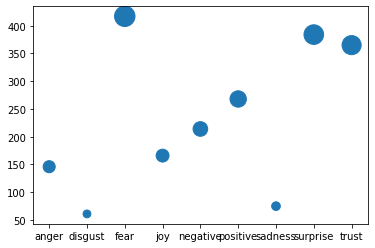

Text(0.5, 0, 'Emotion')

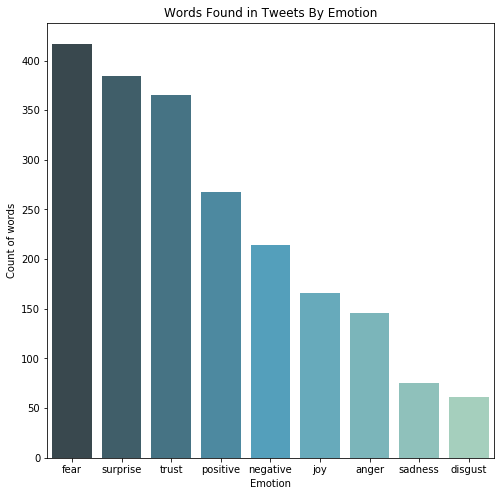

In [69]:
# declare the threshold
threshold = 0.35

df_emotion2= df_emotion[df_emotion['similarity_score']  > threshold]

x = sorted(df_emotion2['emotion_words'].unique().tolist())
y = df_emotion2['tweet_words'].groupby(df_emotion2['emotion_words']).size().tolist()

emotion_plot = pd.DataFrame(list(zip(x, y)), columns =['emotion_words', 'count'])

#######################################################################################

# scatter plot
plt.scatter(x, y,s= y*10000)
plt.show()

#######################################################################################

#Plot bar graph for emotional engagement
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
sns_plot = sns.barplot(x="emotion_words", y = "count", data=emotion_plot.sort_values(by = 'count', ascending= False),
                 palette="GnBu_d")
ax.set_title("Words Found in Tweets By Emotion")
plt.ylabel('Count of words')
plt.xlabel('Emotion')

#######################################################################################


### Conclusion on Emotion Classification

If you look at the words classified by emotions, this doesn't look so accurate as there is no package like get_nrc_sentiment() in R. It needs to build Deep Learning concepts in depth to convert the words accurately. Still en_core_web_md module in spacy gives somewhat accurate as compared to en_core_web_sm, but you can also use en_core_web_lg(~800mb) if you have faster servers or processors. If you know more accurate way then let me know, it would be helpful.